In [1]:
!nvidia-smi 

Thu Jul  8 12:14:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    44W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!git clone https://github.com/aksh-ai/skull-stripping-task.git 

In [4]:
import os
os.chdir("skull-stripping-task")

In [5]:
!pip install --quiet -r requirements.txt
!unzip -qq '/content/drive/My Drive/data.zip'
!unzip -qq '/content/drive/My Drive/T1w_MRI_test_data.zip'

In [6]:
import torch
import random
from torch import nn
import numpy as np
import torchvision
import torchio as tio
from lib.data import *
from lib.utils import *
from lib.losses import *
from lib.layers import *
from lib.models import ResidualUNET3D
from lib.runners import *
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from pathlib import Path 
import nibabel as nib
from nilearn import plotting

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [7]:
torch.backends.cudnn.benchmark = True 

In [8]:
root = Path('data')
images_dir = root / 'images'
labels_dir = root / 'labels'

device= "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 6
patch_size = 64
overlap_size = 16
test_size = 0.2
epochs = 6

model_dir = 'models'
log_dir = '/content/drive/My Drive/skull_stripping_logs - resUNET3d mse 2'

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

images = sorted(images_dir.glob('*.nii.gz'))
labels = sorted(labels_dir.glob('*.nii.gz'))

In [9]:
train_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.RandomMotion(p=0.3),
        tio.HistogramStandardization({'mri': np.load('NFBS_histogram_landmarks.npy')}),
        tio.RandomBiasField(p=0.3),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean),
        tio.RandomNoise(p=0.49),
        tio.RandomFlip(),
        tio.OneOf({
            tio.RandomAffine(): 0.6,
            tio.RandomElasticDeformation(): 0.4,
        })
    ])

valid_transforms = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(1),
        tio.HistogramStandardization({'mri': np.load('NFBS_histogram_landmarks.npy')}),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean)
    ])

In [10]:
training_set, validation_set = load_datasets(images, labels, patch_size=patch_size, volume="patches", test_size=test_size, train_transforms=train_transforms, valid_transforms=valid_transforms, random_state=52)

Volume Mode: PATCHES | Dataset: 125 Images
Training set: 12800 Images
Validation set: 3200 Images


In [11]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size//2)

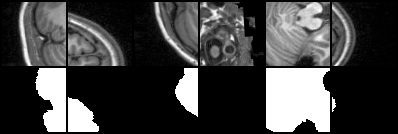

In [12]:
k = (patch_size // 2) + 2
for _ in range(2): batch = next(iter(train_loader))
batch_mri = batch['mri'][tio.DATA][..., k]
batch_label = batch['brain'][tio.DATA][:, :, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=batch_size,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

In [13]:
model = ResidualUNET3D(in_channels=1, out_channels=1)

if "cuda" in device:
  model = torch.nn.DataParallel(model).to(device)

In [14]:
print(model) 

DataParallel(
  (module): ResidualUNET3D(
    (conv1_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (act1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv1_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (conv1_short): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (residual_block1): ResidualBlock3D(
      (norm1): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act2): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), 

In [15]:
total_parameters = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_parameters - trainable
print(f"Number of parameters in the model: {total_parameters}")
print(f"Number of trainable parameters in the model: {trainable}")
print(f"Number of non-trainable parameters in the model: {non_trainable}")

Number of parameters in the model: 23766848
Number of trainable parameters in the model: 23766848
Number of non-trainable parameters in the model: 0


In [16]:
criterion = StandardSegmentationLoss(loss_type='MSE').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 4e-5)
tensorboard = get_tensorboard(log_dir)

In [17]:
train_loss, valid_loss = train(train_loader, valid_loader, model, optimizer, criterion, epochs, device, scheduler=scheduler, verbose=400, model_path=os.path.join(model_dir, 'residual_unet3d_mse'))

Epoch [1/6]
Train - Batch [     1/2134] | Loss: 0.606206 | Dice Coefficient: 0.178763 | Jaccard (IoU) Score: 0.098155
Train - Batch [   400/2134] | Loss: 0.025841 | Dice Coefficient: 0.814713 | Jaccard (IoU) Score: 0.687356
Train - Batch [   800/2134] | Loss: 0.023336 | Dice Coefficient: 0.927142 | Jaccard (IoU) Score: 0.864179
Train - Batch [  1200/2134] | Loss: 0.126444 | Dice Coefficient: 0.728765 | Jaccard (IoU) Score: 0.573273
Train - Batch [  1600/2134] | Loss: 0.027916 | Dice Coefficient: 0.941645 | Jaccard (IoU) Score: 0.889724
Train - Batch [  2000/2134] | Loss: 0.038707 | Dice Coefficient: 0.914783 | Jaccard (IoU) Score: 0.842949
Train - Batch [  2134/2134] | Loss: 0.006807 | Dice Coefficient: 0.967098 | Jaccard (IoU) Score: 0.936293
Validation - Batch [     1/1067] | Loss: 0.023910 | Dice Coefficient: 0.915259 | Jaccard (IoU) Score: 0.843759
Validation - Batch [   400/1067] | Loss: 0.028591 | Dice Coefficient: 0.947903 | Jaccard (IoU) Score: 0.900965
Validation - Batch [   8

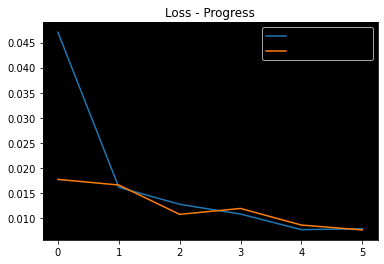

In [18]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title("Loss - Progress")
plt.legend()
plt.show()

In [19]:
torch.save(model.state_dict(), os.path.join(model_dir, 'residual_unet3d.pth'))

In [20]:
loss, dice, iou = evaluate(valid_loader, model, criterion, device)
print(f"Overall Validation Metrics - Loss: {loss:.6f} Dice: {dice:.6f} IOU: {iou:.6f}")

Overall Validation Metrics - Loss: 0.008068 Dice: 0.917600 IOU: 0.875256


In [21]:
test_images = ['T1Img/sub-01/T1w.nii.gz', 'T1Img/sub-02/anat_img.nii.gz', 'T1Img/sub-03/T1w MRI.nii', 'T1Img/sub-04/T1w MRI.nii', 'T1Img/sub-05/T1w MRI.nii']
saved_imgs = []

Test set evaluation
Image: T1Img/sub-01/T1w.nii.gz


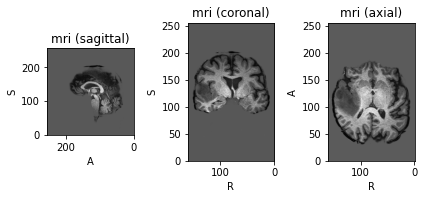

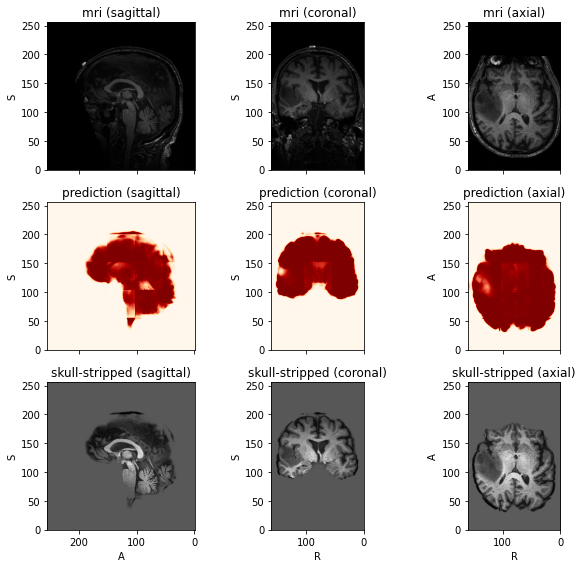

Image: T1Img/sub-02/anat_img.nii.gz


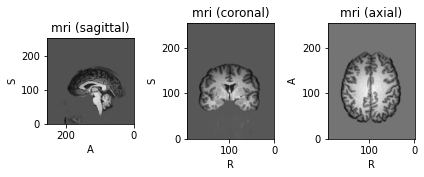

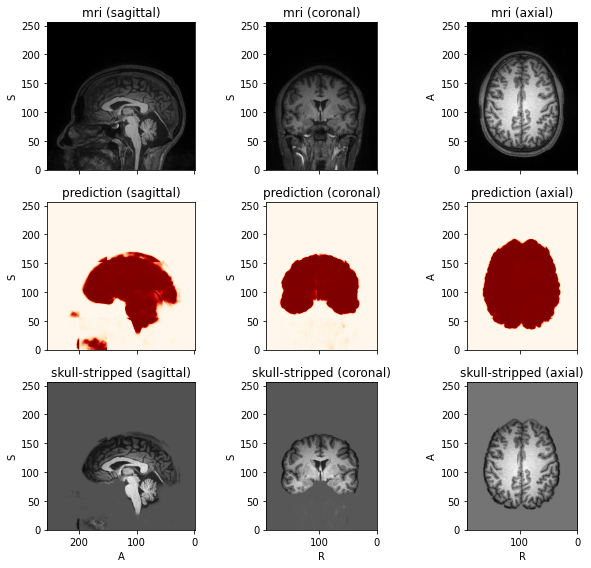

Image: T1Img/sub-03/T1w MRI.nii


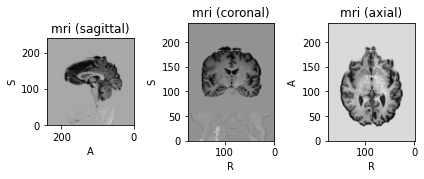

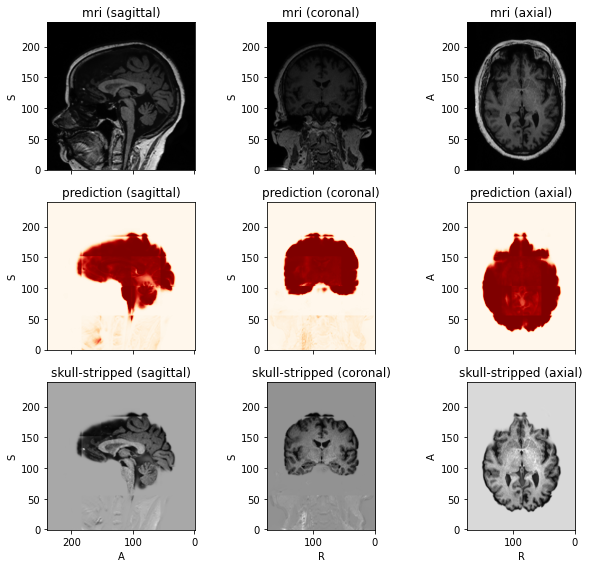

Image: T1Img/sub-04/T1w MRI.nii


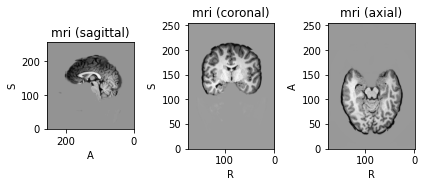

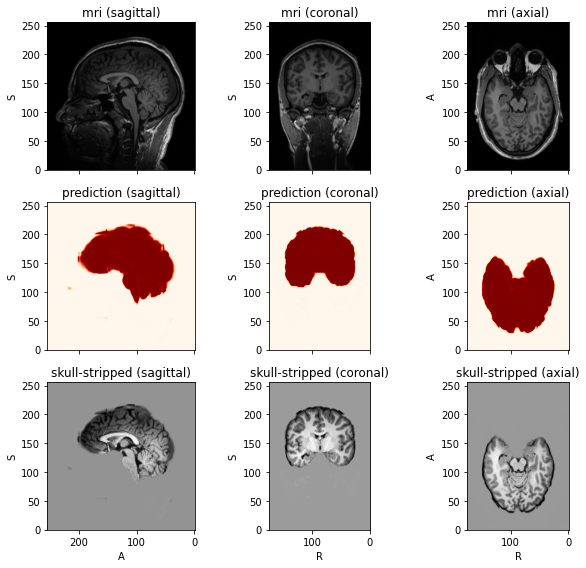

Image: T1Img/sub-05/T1w MRI.nii


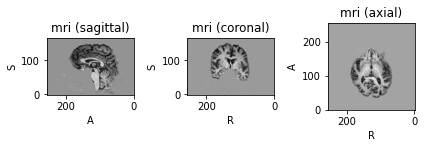

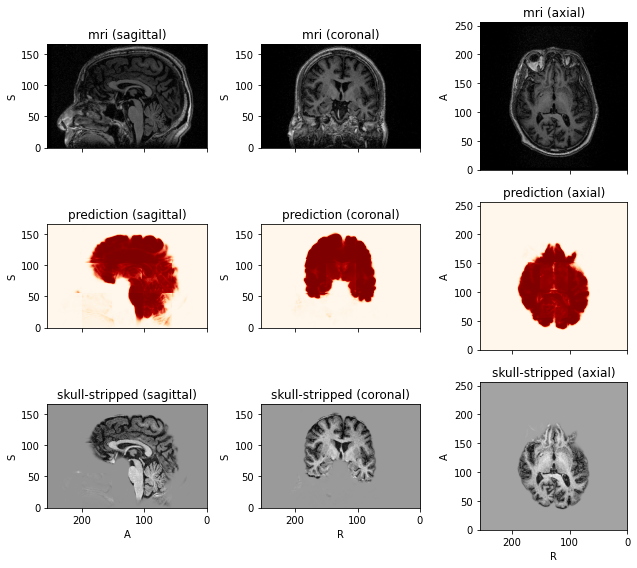

In [25]:
print("Test set evaluation")
for image in test_images:
  print(f"Image: {image}")
  save_path = image.split('.')[0] + '_skull_stripped.nii.gz'
  saved_imgs.append(save_path)

  original, stripped, mask = infer(image, save_path, model, patch_size=patch_size, overlap=overlap_size, batch_size=batch_size, device=device, visualize=True, return_tensors=True)

  subject = tio.Subject(mri=tio.ScalarImage(tensor=original))
  subject.add_image(tio.ScalarImage(tensor=mask), 'prediction')
  subject.add_image(tio.ScalarImage(tensor=stripped), 'skull-stripped')
  subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'OrRd'})

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:110: UserWarning: Threshold given was 1e-06, but the data has no values below -2.9630017280578613. 
  data.min()))



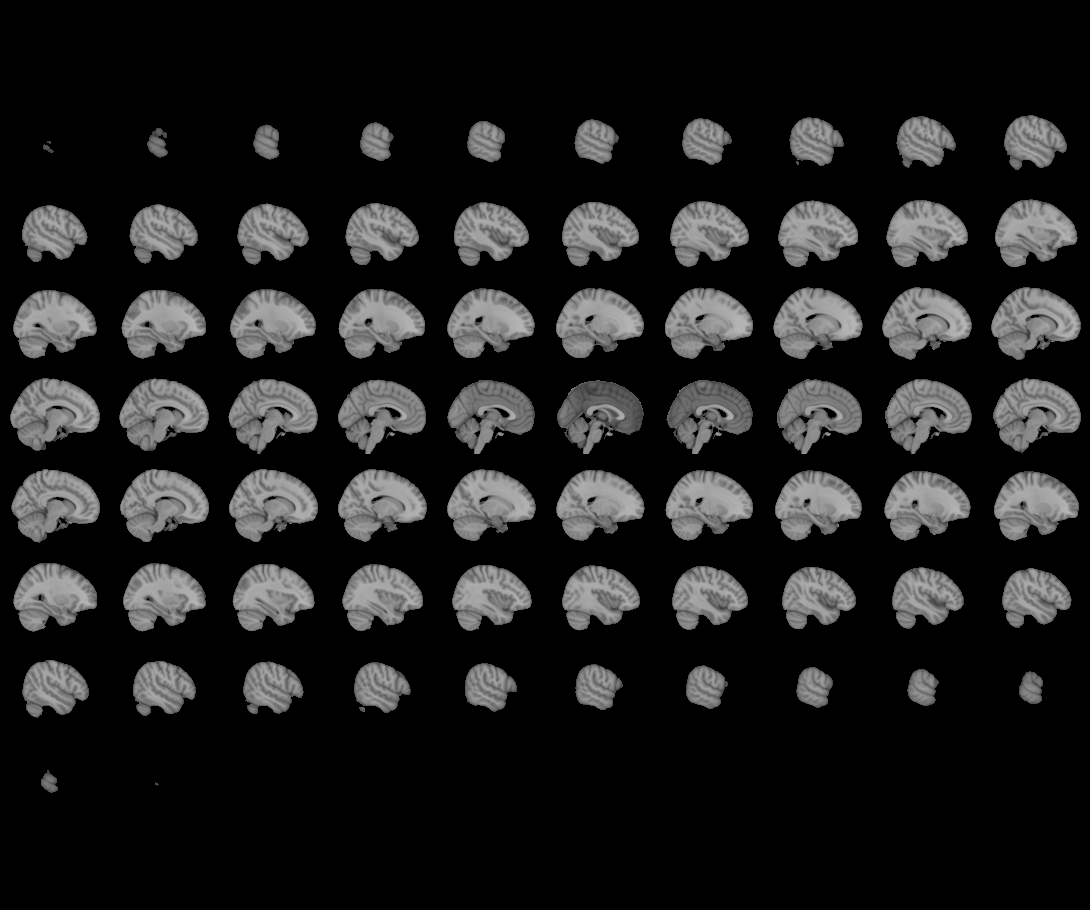
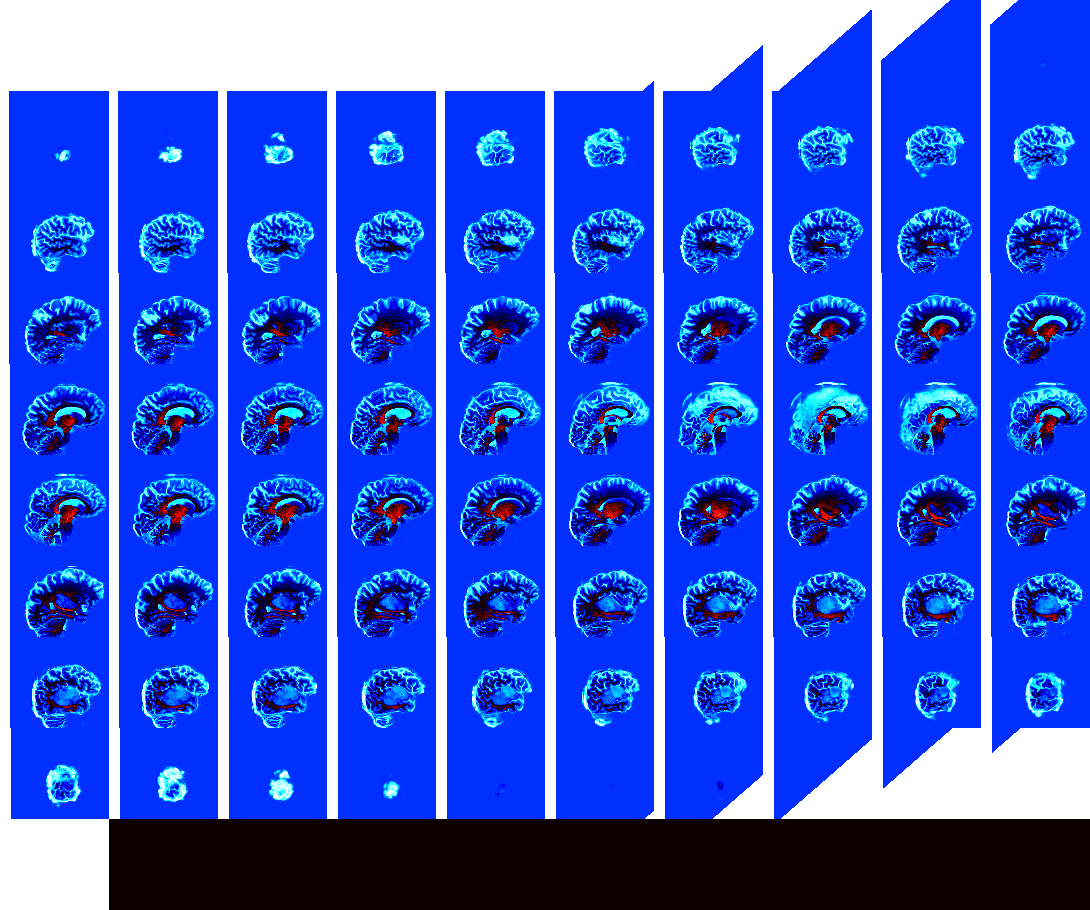

In [26]:
plotting.view_img(saved_imgs[0])

In [27]:
torch.save(model.state_dict(), '/content/drive/My Drive/residual_unet3d_MSE_2.pth')